In [ ]:
![ -e 'battleground-state-changes.csv' ] || wget https://raw.githubusercontent.com/alex/nyt-2020-election-scraper/master/battleground-state-changes.csv
#![ -e 'zip.train' ] || wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz && gzip -d zip.train.gz
#![ -e 'zip.test' ] || wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz && gzip -d zip.test.gz

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from enum import Enum

In [ ]:
class Colors(Enum):
    blue = '#0A85FF'
    darkblue = '#00264D'
    green = '#99CC00'
    darkgreen = '#739900'

In [ ]:
battleground_path = './battleground-state-changes.csv'
df = pd.read_csv(battleground_path)

In [ ]:
# Restructure data frame for easier access to Biden and Trump votes

def get_candidate_votes(row):
    if row['leading_candidate_name'] == 'Biden':
        row['biden_votes'] = row['leading_candidate_votes']
        row['trump_votes'] = row['trailing_candidate_votes']
    elif row['leading_candidate_name'] == 'Trump':
        row['biden_votes'] = row['trailing_candidate_votes']
        row['trump_votes'] = row['leading_candidate_votes']
    return row

df = df.apply(get_candidate_votes, axis=1)

In [ ]:
df

,state,timestamp,leading_candidate_name,trailing_candidate_name,leading_candidate_votes,trailing_candidate_votes,vote_differential,votes_remaining,new_votes,new_votes_relevant,new_votes_formatted,leading_candidate_partition,trailing_candidate_partition,precincts_reporting,precincts_total,hurdle,hurdle_change,hurdle_mov_avg,counties_partition,total_votes_count,biden_votes,trump_votes
0,Alaska (EV: 3),2020-11-25 02:25:12.858000,Trump,Biden,189543,153502,36041,7204,2314,432,432,0.136574,0.863426,441,441,3.116356,0.618831,0.495733,{},358802,153502,189543
1,Alaska (EV: 3),2020-11-25 01:59:12.313000,Trump,Biden,189484,153129,36355,9518,-308,-395,Unknown,-0.068354,1.068354,423,441,2.497525,-0.041306,0.481900,{},356488,153129,189484
2,Alaska (EV: 3),2020-11-24 13:22:21.458000,Trump,Biden,189457,153551,35906,9210,0,0,0,0.000000,0.000000,423,441,2.538831,0.000000,0.489933,{},356796,153551,189457
3,Alaska (EV: 3),2020-11-19 13:18:50.262000,Trump,Biden,189457,153551,35906,9210,7323,6977,"6,977",0.528594,0.471406,407,441,2.538831,0.915685,0.489933,"{'ED 1': 164, 'ED 10': 312, 'ED 11': 174, 'ED ...",356796,153551,189457
4,Alaska (EV: 3),2020-11-18 17:25:33.757000,Trump,Biden,185769,150262,35507,16533,0,0,0,0.000000,0.000000,389,441,1.623146,0.000000,0.514500,{},349473,150262,185769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Pennsylvania (EV: 20),2020-11-04 15:17:08.834000,Trump,Biden,2977987,2390331,587656,1386781,4275,4249,"4,249",0.298659,0.701341,6943,9128,0.714537,0.000037,0.819567,{'Luzerne': 4275},5441186,2390331,2977987
756,Pennsylvania (EV: 20),2020-11-04 14:56:08.718000,Trump,Biden,2976718,2387351,589367,1391056,88,87,87,0.413793,0.586207,6938,9128,0.714500,0.000008,0.839200,{'Dauphin': 88},5436911,2387351,2976718
757,Pennsylvania (EV: 20),2020-11-04 14:32:18.760000,Trump,Biden,2976682,2387300,589382,1391144,39561,39269,"39,269",0.160075,0.839925,6938,9128,0.714492,-0.003516,0.839925,{'Montgomery': 39561},5436823,2387300,2976682
758,Pennsylvania (EV: 20),2020-11-04 14:23:44.006000,Trump,Biden,2970396,2354317,616079,1430705,4580,4545,"4,545",0.196260,0.803740,6905,9128,0.718008,-0.000278,0.803740,{'Lehigh': 4580},5397262,2354317,2970396


In [ ]:
class LinearRegression():
  def __init__(self, w=0, b=0):
    self.w = w
    self.b = b

  # def fit(X,y):
  #   w = 0
  #   b = 0
  #   return LinearRegression(w,b)
  
  def fit(self, X, y):
    X_u = np.hstack([X, np.ones_like(X[:, 0]).reshape([-1, 1])])
    wb = np.linalg.pinv(X_u) @ y
    # y ≈ X_u @ wb = X @ w + b
    w, b = wb[:-1], wb[-1]
    self.w = w
    self.b = b
    return self
  
  def predict(self, x):
    """ 
    Define the line here.
    Map x to it's y coordinates. The set {(x,y) | x from input, y from output} 
    should define your line.
    In this case x will be percentages reported like
    np.linspace(0.94, 1, 100).reshape([-1,1]) from 94% to 100%
    in Georgia
    """

    return x @ self.w + self.b



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Text(0.5, 0, "Trump's percentage lead")

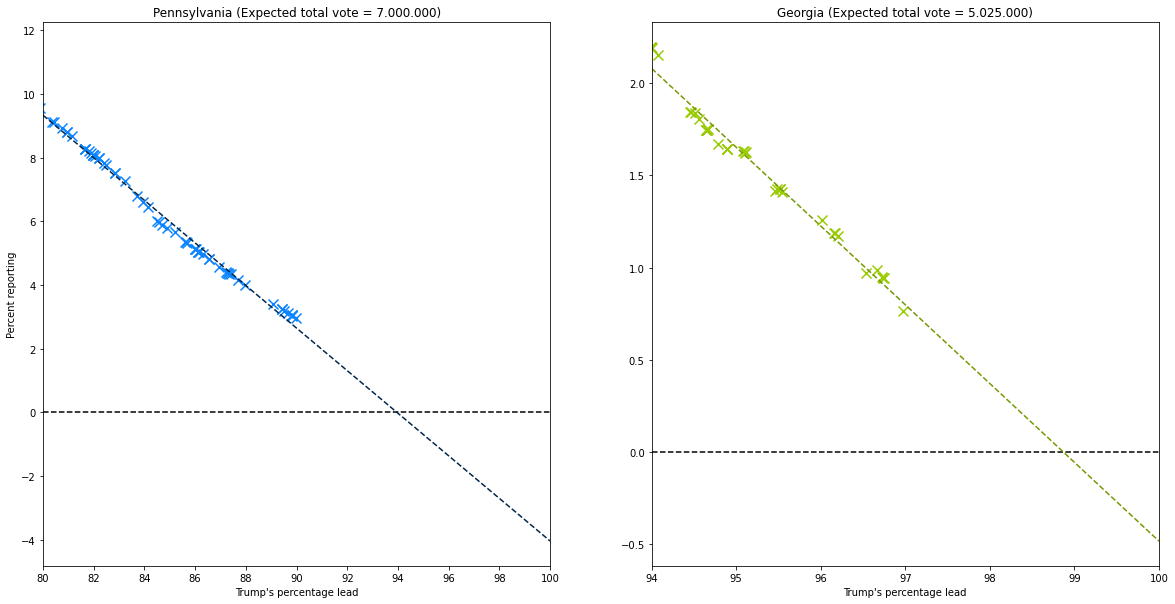

In [ ]:
#Pennsylvania
df_py = df[df['state'] == 'Pennsylvania (EV: 20)']
df_py['percent_reporting'] = df_py['total_votes_count'] / int(7e+6)
df_py['trump_lead'] = (df_py['trump_votes'] - df_py['biden_votes']) / df_py['total_votes_count']
df_py = df_py.sort_values('percent_reporting', axis=0, ascending=False)

# Only view votes that were counted before 90% were reported
df_py = df_py[df_py['percent_reporting'] <= 0.9]

X = df_py['percent_reporting'].to_numpy().reshape([-1, 1])
y = df_py['trump_lead'].to_numpy()

# Fit X to y using Linear Regression
linear_py = LinearRegression().fit(X, y)


#Georgia
df_ga = df[df['state'] == 'Georgia (EV: 16)']
df_ga['percent_reporting'] = df_ga['total_votes_count'] / int(5.025e+6)
df_ga['trump_lead'] = (df_ga['trump_votes'] - df_ga['biden_votes']) / df_ga['total_votes_count']
df_ga = df_ga.sort_values('percent_reporting', axis=0, ascending=False)

# Only view votes that were counted before 97% were reported
df_ga = df_ga[df_ga['percent_reporting'] <= 0.97]

X = df_ga['percent_reporting'].to_numpy().reshape([-1, 1])
y = df_ga['trump_lead'].to_numpy()

# Fit X to y using Linear Regression
linear_ga = LinearRegression().fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(df_py['percent_reporting'] * 100, df_py['trump_lead'] * 100, marker='x', s=100, color=Colors.blue.value)
x = np.linspace(0.8, 1, 100).reshape([-1,1])
y = linear_py.predict(x)
ax[0].set_xlim([85, 100])
ax[0].set_xticks(range(80, 101, 2))
ax[0].plot(x * 100, y * 100, linestyle='--', color=Colors.darkblue.value)
ax[0].hlines(y=0, xmin=80, xmax=100, linestyle='--', color='black')
ax[0].set_title('Pennsylvania (Expected total vote = 7.000.000)')

ax[1].scatter(df_ga['percent_reporting'] * 100, df_ga['trump_lead'] * 100, marker='x', s=100, color=Colors.green.value)
x = np.linspace(0.94, 1, 100).reshape([-1,1])
y = linear_ga.predict(x)
ax[1].set_xlim([94, 100])
ax[1].set_xticks(range(94, 101, 1))
ax[1].plot(x * 100, y * 100, linestyle='--', color=Colors.darkgreen.value)
ax[1].hlines(y=0, xmin=94, xmax=100, linestyle='--', color='black')
ax[1].set_title('Georgia (Expected total vote = 5.025.000)')

ax[0].set_ylabel("Percent reporting")
ax[0].set_xlabel("Trump's percentage lead")
ax[1].set_xlabel("Trump's percentage lead")
# plt.savefig('trump_lead.svg', transparent=True)

At what percentage of reported votes will Biden lead over Trump?

In [ ]:
for state, model in (('py', linear_py), ('ga', linear_ga)):
  print(state + ':', -model.b / model.w)

py: [0.93957541]
ga: [0.98868753]


Pennsylvania — at 94%

Georgia — at 99%